In [1]:
import sys

DATA_PATH = '../../IFT6758_Data/'
PROJECT_PATH = '../../Milestone2/'


sys.path.append(PROJECT_PATH)

In [2]:
from comet_ml import Experiment
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
import shap
import pickle
import matplotlib.pyplot as plt
import sklearn
import imblearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, SelectFromModel
import os
import xgboost as xgb

from visualizations.simple_visualization import *
from models.generate_plots import *
from features.feature_eng1 import *

In [3]:
X = pd.read_csv(DATA_PATH + '/clean_train_data.csv', index_col=0)

In [4]:
has_nan = X.isna().any().any()

if has_nan:
    print("There are NaN values in the DataFrame 'X'.")
    # Dropping NaNs since these events do not have x and y coordinates
    X.dropna(inplace=True)
    X = X.reset_index(drop=True)
else:
    print("There are no NaN values in the DataFrame 'X'.")
X.shape
X.dtypes
X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
X = X.reset_index(drop=True)

There are NaN values in the DataFrame 'X'.


In [5]:
X, y = X.iloc[:, :-1], X.iloc[:, -1]
y.value_counts(normalize=True).round(2)*100

0    91.0
1     9.0
Name: is_goal, dtype: float64

In [6]:
num_cols = X.select_dtypes([np.number]).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

categorical_cols = X.select_dtypes(exclude=["number", "bool_"]).columns
X = pd.get_dummies(data=X, columns=categorical_cols)

boolean_cols = X.select_dtypes([bool]).columns
X[boolean_cols] = X[boolean_cols].astype(int)
X = X.reset_index(drop=True)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [8]:
tomek = imblearn.under_sampling.TomekLinks()
X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)

In [9]:
params = {'objective':'binary:logistic',
 'booster': 'gbtree',
 'lambda': 0.33121383940964394,
 'alpha': 7.269895266157583e-05,
 'max_depth': 9,
 'eta': 0.0965393557819441,
 'gamma': 3.264214468562427e-06,
 'grow_policy': 'depthwise'}

model = xgb.XGBClassifier(**params)

model.fit(X_tomek, y_tomek)

XGBClassifier(alpha=7.269895266157583e-05, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eta=0.0965393557819441,
              eval_metric=None, gamma=3.264214468562427e-06, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=0.33121383940964394,
              learning_rate=0.0965393558, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

In [10]:
y_pred = model.predict(X_val)
accuracy = metrics.accuracy_score(y_val, y_pred)
print(f'Accuracy score is {accuracy}')

Accuracy score is 0.9086466003530982


In [11]:
tomek_f1 = metrics.f1_score(y_val, y_pred)
tomek_accuracy = metrics.accuracy_score(y_val, y_pred)
tomek_precision = metrics.precision_score(y_val, y_pred)
tomek_recall = metrics.recall_score(y_val, y_pred)

In [12]:
pickle.dump(model, open("tomek_xgb_model.pkl", "wb"))

In [13]:
experiment = Experiment(
  api_key='lqXuPyhuPClaazZKtvHZe5jFS',
  project_name="nhl-project-b10",
  workspace="ift6758b-project-b10"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758b-project-b10/nhl-project-b10/03e1ba00a55243f3be18c6bd3c7f3e67



In [14]:
evaluation = {"accuracy": tomek_accuracy, "f1": tomek_f1, "recall": tomek_recall, "precision": tomek_precision}
params = {
    "model": 'XGBoost with Tomek Links',
    "description": 'XGBoost Classifier with Tomek Links',
    **model.get_params()
}

In [15]:
experiment.set_name('XGBoost with Tomek Links')
experiment.log_parameters(params)
experiment.log_metrics(evaluation)

experiment.log_model('6-2 XGBoost Classifier with Tomek Links', 'tomek_xgb_model.pkl')

{'web': 'https://www.comet.com/api/asset/download?assetId=bed68558cb6a405fa94891e8fc8b5730&experimentKey=03e1ba00a55243f3be18c6bd3c7f3e67',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=bed68558cb6a405fa94891e8fc8b5730&experimentKey=03e1ba00a55243f3be18c6bd3c7f3e67',
 'assetId': 'bed68558cb6a405fa94891e8fc8b5730'}

In [16]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758b-project-b10/nhl-project-b10/03e1ba00a55243f3be18c6bd3c7f3e67
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.9086466003530982
COMET INFO:     f1        : 0.05120751341681574
COMET INFO:     precision : 0.541371158392435
COMET INFO:     recall    : 0.026874779955404295
COMET INFO:   Others:
COMET INFO:     Name : XGBoost with Tomek Links
COMET INFO:   Parameters:
COMET INFO:     alpha                   : 7.269895266157583e-05
COMET INFO:     base_score              : 0.5
COMET INFO:     booster                 : gbtree
COMET INFO:     callbacks               : None
COMET INFO:     colsample_bylevel       : 1
COMET I

In [17]:
y_pred_prob = model.predict_proba(X_val)[:, 1]
df_percentile =  calc_percentile(y_pred_prob, y_val)

goal_rate_df = goal_rate(df_percentile)

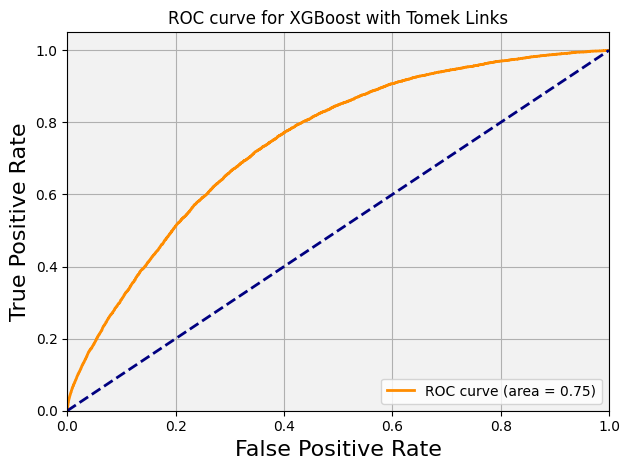

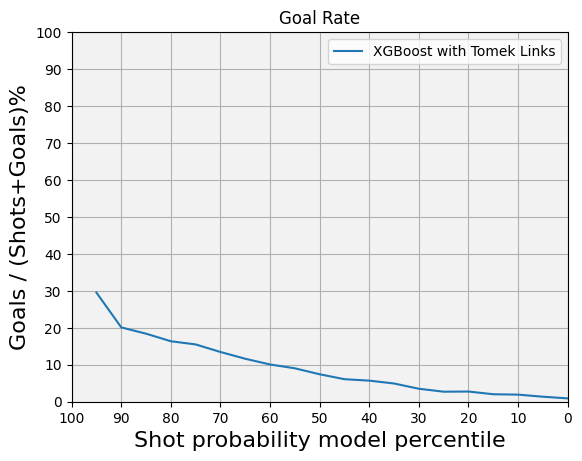

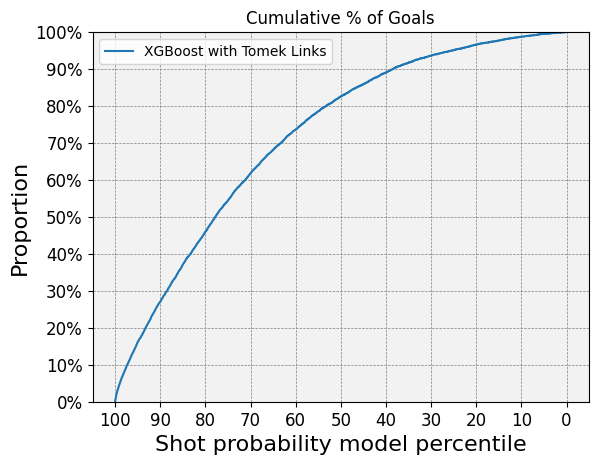

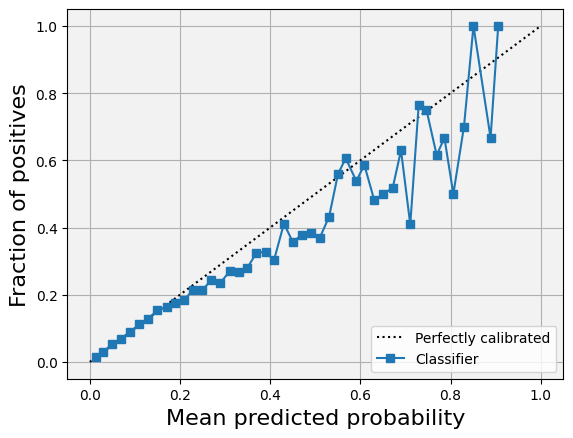

In [18]:
plot_ROC(y_val, y_pred_prob, 'ROC curve for XGBoost with Tomek Links', '6-2a ROC Curve')
plot_goal_rates(goal_rate_df, 'XGBoost with Tomek Links', '6-2b Goal Rate')
plot_cumulative_goal_rates(df_percentile, 'XGBoost with Tomek Links', '6-2c Cumulative Goal Percentage')
plot_calibration_curve_prediction(y_val, y_pred_prob, '6-2d Calibration Plot')